The aim of this notebook is to find the best fit to the weight distribution from at least one of the empirical sociopatterns datasets.

The aim of this notebook was not acheived, the network generated using this the 'test_func' to define its weights had a far greater rate of infection, despite having at most 3x the number of nodes as the original network. This is due to the weight generation assigning far higher weights than suitable. We do possess a suitable fit for the degree distribution but similar remains to be found for the weight distribution. 

/var/folders/32/x1s5292x3ql29vds9pxmydb80000gp/T/ipykernel_84076/1352587178.py:29: RuntimeWarning: overflow encountered in exp
  return  b * ((x)**c) / np.exp(x*a)
/var/folders/32/x1s5292x3ql29vds9pxmydb80000gp/T/ipykernel_84076/1352587178.py:29: RuntimeWarning: overflow encountered in power
  return  b * ((x)**c) / np.exp(x*a)
/var/folders/32/x1s5292x3ql29vds9pxmydb80000gp/T/ipykernel_84076/1352587178.py:29: RuntimeWarning: divide by zero encountered in true_divide
  return  b * ((x)**c) / np.exp(x*a)
/var/folders/32/x1s5292x3ql29vds9pxmydb80000gp/T/ipykernel_84076/1352587178.py:29: RuntimeWarning: overflow encountered in true_divide
  return  b * ((x)**c) / np.exp(x*a)
/var/folders/32/x1s5292x3ql29vds9pxmydb80000gp/T/ipykernel_84076/1352587178.py:29: RuntimeWarning: overflow encountered in multiply
  return  b * ((x)**c) / np.exp(x*a)


  best scaling factor    best average error
---------------------  --------------------
                 2.81                  1.56


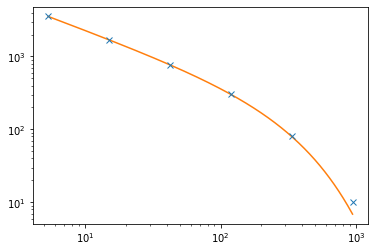

[ 2.88034685e-03  1.14064066e+04 -6.88133326e-01]
[3.8851643  0.42758485 0.36956293]


In [37]:
import network_stats as ns
import network_manipulation as nm
import numpy as np
import matplotlib.pyplot as plt


# should make this into a file to inport into every notebook
dataset_paths = [
'Sociopatterns datasets/conference_2009.dat_',
'Sociopatterns datasets/highschool_2011.csv',
'Sociopatterns datasets/highschool_2012.csv',
'Sociopatterns datasets/highschool_2013.csv',
'Sociopatterns datasets/hospital_2010.dat_',
'Sociopatterns datasets/primaryschool_2014.csv',
'Sociopatterns datasets/workplace_2013.dat',
'Sociopatterns datasets/workplace_2015.dat_']

dataset_names = [
    'Conference 1', 
    'Highschool 1', 
    'Highschool 2', 
    'Highschool 3', 
    'Hospital 1', 
    'Primaryschool 1', 
    'Workplace 1', 
    'Workplace 2']

def test_func(x, a, b, c):
    return  b * ((x)**c) / np.exp(x*a)
'''
def test_func(x, a, b, c):
    return  b * (x*c+a) * np.exp(x*c+a)
    
    
def weight_func(x, a, b, c):
    return  b * ((x)**c) / np.exp(x*a)
    

'''

G = nm.build_nxgraph(dataset_paths[0], False) 
d, w = ns.analyse_graph(G)
scales = np.arange(1.5, 3.0, 0.01)
scale, scale_err = ns.compare_scale(test_func, w, scales, False, False)
wfit, werr = ns.check_fit(test_func, ns.log_binning, w, [scale, False] , False,True, 'log')
print(wfit)
print(werr)

Text(0.5, 1.0, 'cdf')

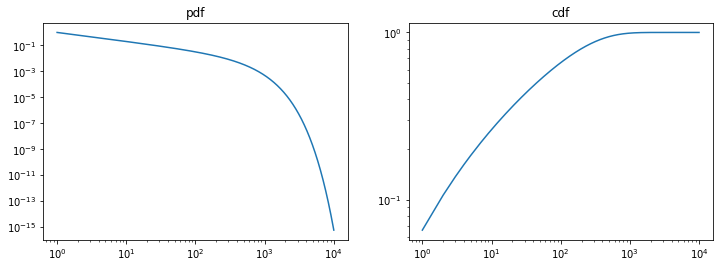

In [119]:
x = np.arange(1, 10000)
y = test_func(x, *wfit)

figure, axis = plt.subplots(1, 2)
figure.set_figwidth(12)

pdf = y / max(y)
axis[0].plot(x, pdf)
axis[0].set_yscale('log')
axis[0].set_xscale('log')
axis[0].set_title('pdf')

cdf = np.cumsum(pdf)
cdf = cdf / max(cdf)
axis[1].plot(x, cdf)
axis[1].set_yscale('log')
axis[1].set_xscale('log')
axis[1].set_title('cdf')

original avg weight: 7.345635128071092
generated average weight: 133.77852114624042
weight ratio: 18.21197470522466


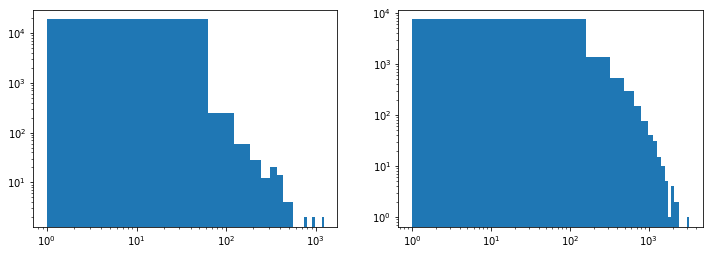

In [122]:
from scipy.interpolate import interp1d

def sample_weights(x, cdf, num_samples):
    u = np.random.uniform(min(cdf), max(cdf), num_samples)
    func_interp = interp1d(cdf, x)
    samples = func_interp(u)
    return samples

def set_weights(G):
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        num_edges = len(connections)
        if num_edges == 0:
            print('What the dog doin')
        else:
            weights = sample_weights(x, cdf, num_edges)
        for i, connection in enumerate(connections):
            G[node][connection]['weight'] = weights[i]
    return G   

figure, axis = plt.subplots(1, 2)
figure.set_figwidth(12)

axis[0].hist(w, bins = 20)
axis[0].set_yscale('log')
axis[0].set_xscale('log')


samples = sample_weights(x, cdf, 10000)
axis[1].hist(samples, bins = 20)
axis[1].set_yscale('log')
axis[1].set_xscale('log')

original_avg_weight = sum(w) / len(w)
generated_avg_weight = sum(samples) / len(samples)
weight_ratio = generated_avg_weight / original_avg_weight

print('original avg weight: ' + str(original_avg_weight))
print('generated average weight: ' + str(generated_avg_weight))
print('weight ratio: ' + str(weight_ratio))

2557.6505135583216
1220.0
1.0019947137668415
1.0


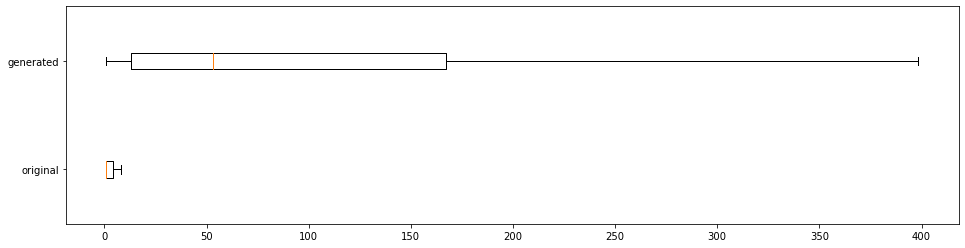

In [121]:
plt.figure(figsize=(16, 4))
plt.boxplot([w, samples], notch  = 0, sym = '', vert = False, labels = ['original', 'generated'])

print(max(samples))
print(max(w))

print(min(samples))
print(min(w))

array([2.10390059e-08, 8.63500062e-09, 7.03734161e-09, ...,
       1.16038749e-08, 1.84999238e-11, 3.55250188e-09])

In [4]:
import scipy.stats as sps
import networkx as nx

dfit, dcov = ns.fit_degrees(d)

class degree_distribution(sps.rv_continuous): 
    def _pdf(self, x):
        return ns.degree_func(x, *dfit)

ddist = degree_distribution(a=0)
degree_samples = ddist.rvs(size = 1000) # 1000 samples, 2.5x bigger for network[0]
degree_samples = np.ceil(degree_samples).astype(int)
degree_samples = [ds for ds in degree_samples if ds != 0] # removes any zeros

print(sum(degree_samples))
if sum(degree_samples)%2 != 0:
    degree_samples = np.append(degree_samples, 35) # chose this as seems to be average from graph
print(sum(degree_samples))

H = nx.configuration_model(degree_samples, create_using = nx.Graph)
H = set_weights(H)

/Users/ali/MSci Project/network_stats.py:104: RuntimeWarning: divide by zero encountered in true_divide
  return (x**a) / np.exp(b*x+c)
/Users/ali/MSci Project/network_stats.py:104: RuntimeWarning: overflow encountered in exp
  return (x**a) / np.exp(b*x+c)
/Users/ali/MSci Project/network_stats.py:104: RuntimeWarning: overflow encountered in double_scalars
  return (x**a) / np.exp(b*x+c)
/Users/ali/MSci Project/network_stats.py:104: RuntimeWarning: invalid value encountered in double_scalars
  return (x**a) / np.exp(b*x+c)
/Users/ali/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/Users/ali/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in _cdf_single (vectorize

35970
35970


In [5]:
node_measures = ns.measure_nodes(H)
network_measures = ns.measure_network(H)

def print_dict(dict):
    for key in list(dict.keys()):
        print(key + ' : ' + str(dict[key]))
    print('\n')

print('Node measures')
print_dict(node_measures)
print('Network measures')
print_dict(network_measures)

# there is a discrepency between sum(degree_samples) and the measures number of
# edges in the network by a factor of 2, this makes sense as each edge will have
# two connections


Node measures
degree : 18.40985324947589
weight : 1425.0569614345184
closeness : 433.9561031073248
betweenness : 1.206858924052307
eigenvector : 29.290062806119536


Network measures
nodes : 954
edges : 17563
ratio : 18.40985324947589
components : 1
density : 0.03863557869774584
path : 2.20432882148616
diameter : 3
transitivity : 0.04441562349973846




0
1
2
3
4


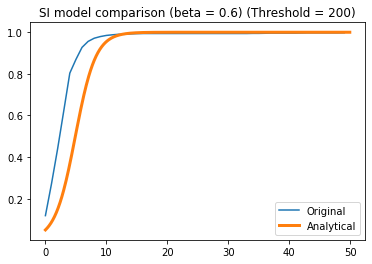

0
1
2
3
4


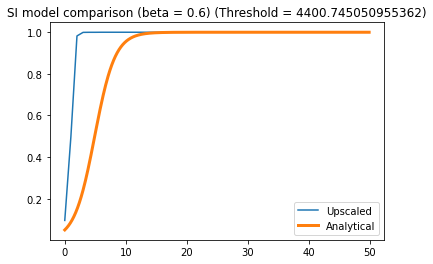

In [10]:
import SI_model_nx as si

simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.6
simulation_params['Runs'] = 5
simulation_params['Threshold'] = 200
simulation_params['Increment'] = 0.1

si.SI_comparison(G, simulation_params, 'Original')

simulation_params['Threshold'] = simulation_params['Threshold'] * weight_ratio

si.SI_comparison(H, simulation_params, 'Upscaled')